In [1]:
import pandas as pd
import geopy.distance
import h3
from tqdm import tqdm
import numpy as np

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
tqdm.pandas()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Params

In [5]:
h3_resolution = 8

# Read data

In [6]:
bolt_ds = pd.read_csv('../data/robotex5.csv')

In [7]:
bolt_ds.shape

(627210, 6)

In [8]:
bolt_ds.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


### Select Estonia and its closest vicinity

In [9]:
mask = ((bolt_ds.start_lat > 57.5) & 
        (bolt_ds.start_lat < 60.0) & 
        (bolt_ds.end_lat > 57.5) & 
        (bolt_ds.end_lat < 60.) &
        (bolt_ds.start_lng > 21.5) & 
        (bolt_ds.start_lng < 28.5) & 
        (bolt_ds.end_lng > 21.5) & 
        (bolt_ds.end_lng < 28.5)
       )
bolt_ds = bolt_ds[mask]

In [10]:
bolt_ds.shape

(626775, 6)

# Prepare extra features

In [11]:
bolt_ds['distance_in_km'] = bolt_ds.progress_apply(lambda x: geopy.distance.geodesic((x.start_lat,x.start_lng),
                                                                                     (x.end_lat,x.end_lng)).km,
                                                   axis = 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626775/626775 [03:14<00:00, 3220.13it/s]


In [12]:
bolt_ds.start_time = pd.to_datetime(bolt_ds.start_time)

In [13]:
bolt_ds['weekday'] = bolt_ds.start_time.map(lambda x: x.weekday())
bolt_ds['weekend'] = bolt_ds.weekday.map(lambda x: x > 4)
bolt_ds['hour'] = bolt_ds.start_time.map(lambda x: x.hour)

In [14]:
bolt_ds['start_hexagons'] = bolt_ds.progress_apply(lambda x: h3.geo_to_h3(lat = x.start_lat, lng = x.start_lng, resolution = h3_resolution),
                                                   axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626775/626775 [00:14<00:00, 41987.37it/s]


In [15]:
bolt_ds['end_hexagons'] = bolt_ds.progress_apply(lambda x: h3.geo_to_h3(lat = x.end_lat, lng = x.end_lng, resolution = h3_resolution),
                                                   axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626775/626775 [00:14<00:00, 43212.57it/s]


In [16]:
bolt_ds.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,distance_in_km,weekday,weekend,hour,start_hexagons,end_hexagons
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,14.205080,6,True,15,88089bc587fffff,88089b1a97fffff
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,2.050095,3,False,11,88089b1a23fffff,88089b1b13fffff
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,0.774715,6,True,14,88089b1a29fffff,88089b1a25fffff
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,3.041401,3,False,9,88089bc58dfffff,88089bc53bfffff
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,9.209442,6,True,0,88089b1a21fffff,88089b18d5fffff


# Predicting demand

### Data set

In [17]:
features = ['weekend','weekday','hour','start_hexagons']

In [18]:
demand_df = bolt_ds.groupby(by = features).agg({'start_time':'count',
                                                'distance_in_km':'mean',
                                                'ride_value':'mean'})

In [19]:
demand_df = pd.DataFrame(demand_df)
demand_df.reset_index(inplace = True)
demand_df.rename(columns = {'start_hexagons':'end_hexagons'}, inplace = True)

In [20]:
demand_df.head()

,weekend,weekday,hour,end_hexagons,start_time,distance_in_km,ride_value
0,False,0,0,88089b033dfffff,2,13.319888,3.296530
1,False,0,0,88089b0345fffff,1,9.617897,2.390500
2,False,0,0,88089b034dfffff,1,10.594006,2.611023
3,False,0,0,88089b0359fffff,1,14.231389,3.543750
4,False,0,0,88089b0365fffff,2,10.160776,2.525625


### Linear model

In [21]:
#features = ['weekend','weekday','hour','end_hexagons']

In [22]:
# demand_model_transform = ColumnTransformer([
#     ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), features)])

In [23]:
# demand_model = Pipeline([('transform', demand_model_transform),
#                          ('model', LinearRegression())])

In [24]:
# demand_model.fit(demand_df,demand_df['start_time'])

In [25]:
# plt.scatter(demand_model.predict(demand_df), demand_df['start_time'])

In [26]:
# plt.hist(demand_model.predict(demand_df)-demand_df['start_time'],bins = 100)

### XGBoost

In [27]:
# demand_model = Pipeline([('transform', demand_model_transform),
                         # ('model', xgb.XGBRegressor())])

In [28]:
# demand_model.fit(demand_df,demand_df['start_time'])

In [29]:
# plt.scatter(demand_model.predict(demand_df), demand_df['start_time'])

In [30]:
# plt.hist(demand_model.predict(demand_df)-demand_df['start_time'],bins = 100)

In [31]:
demand_df['end_lat'] = demand_df.end_hexagons.map(lambda x: h3.h3_to_geo(x)[0])
demand_df['end_lng'] = demand_df.end_hexagons.map(lambda x: h3.h3_to_geo(x)[1])

In [32]:
demand_df.head()

,weekend,weekday,hour,end_hexagons,start_time,distance_in_km,ride_value,end_lat,end_lng
0,False,0,0,88089b033dfffff,2,13.319888,3.296530,59.528983,24.894365
1,False,0,0,88089b0345fffff,1,9.617897,2.390500,59.522877,24.836750
2,False,0,0,88089b034dfffff,1,10.594006,2.611023,59.524657,24.823816
3,False,0,0,88089b0359fffff,1,14.231389,3.543750,59.551134,24.835514
4,False,0,0,88089b0365fffff,2,10.160776,2.525625,59.506074,24.856763


In [33]:
cat_features = ['weekend','weekday','hour']
num_fetures = ['end_lat','end_lng']

In [34]:
demand_model_transform = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaler', StandardScaler(),num_fetures)])

In [35]:
demand_model = Pipeline([('transform', demand_model_transform),
                         ('model', xgb.XGBRegressor())])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(demand_df[cat_features+num_fetures], demand_df[['start_time']], test_size=0.33, random_state=42)

In [37]:
demand_model.fit(X_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weekend', 'weekday',
                                                   'hour']),
                                                 ('scaler', StandardScaler(),
                                                  ['end_lat', 'end_lng'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

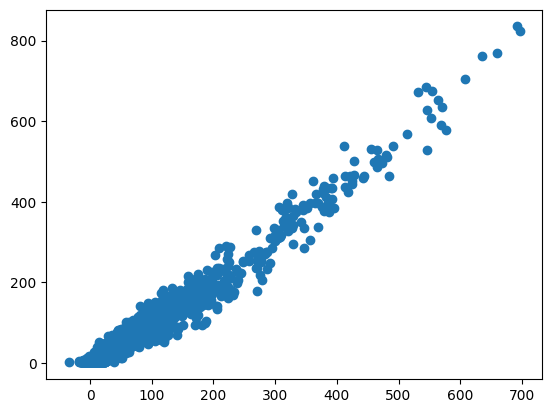

In [38]:
plt.scatter(demand_model.predict(X_train), y_train)

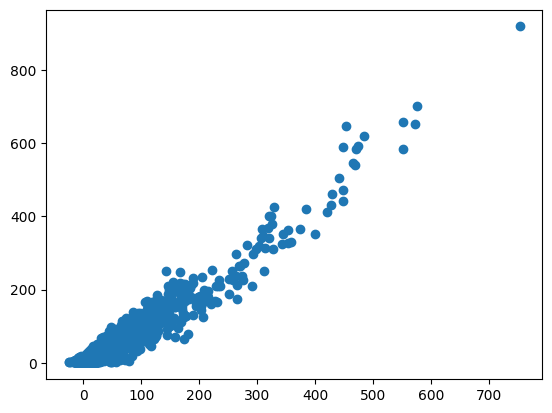

In [39]:
plt.scatter(demand_model.predict(X_test), y_test)

# Predicting ride value

In [40]:
cat_features = ['weekend','weekday','hour']
num_fetures = ['distance_in_km']

In [41]:
ride_value_model_transform = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaler', StandardScaler(),num_fetures)])

In [42]:
ride_value_model = Pipeline([('transform', ride_value_model_transform),
                         ('model', LinearRegression())])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(bolt_ds[cat_features+num_fetures], bolt_ds[['ride_value']], test_size=0.33, random_state=42)

In [44]:
ride_value_model.fit(X_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weekend', 'weekday',
                                                   'hour']),
                                                 ('scaler', StandardScaler(),
                                                  ['distance_in_km'])])),
                ('model', LinearRegression())])

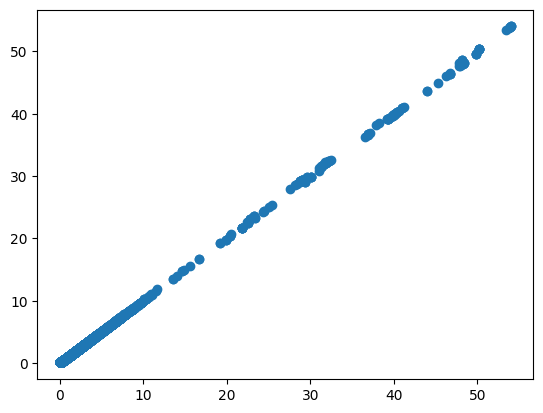

In [45]:
plt.scatter(ride_value_model.predict(X_train),y_train)

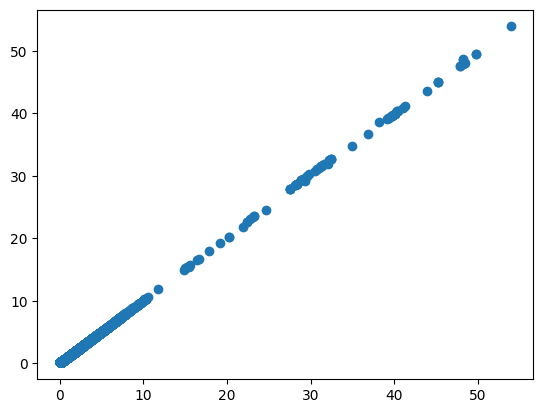

In [46]:
plt.scatter(ride_value_model.predict(X_test),y_test)

# Driver

In [77]:
class bolt_driver:
    
    def __init__(self, start_latitude, start_longitude, start_time, demand_model, ride_value_model, h3_resolution):
        
        self._home_lat = start_latitude
        self._home_lng = start_longitude
        self.current_lat = start_latitude
        self.current_lng = start_longitude
        self.current_time = start_time
        self._demand_model = demand_model
        self._ride_value_model = ride_value_model
        self.h3_resolution = h3_resolution
        self._n_rides = 0
        self._earnings = 0.0
    
    @property
    def current_lat(self):
        return self._current_lat
    
    @current_lat.setter
    def current_lat(self, x):
        if (x < -90) | (x > 90):
            raise ValueError("The latitude range is [-90;90]")
        self._current_lat = x
    
    @property
    def current_lng(self):
        return self._current_lng
    
    @current_lng.setter
    def current_lng(self, x):
        if (x < -180) | (x > 180):
            raise ValueError("The longitude range is [-180;180]")
        self._current_lng = x
    
    @property
    def current_time(self):
        return self._current_time
    
    @current_time.setter
    def current_time(self, x):
        self._current_time = x
        
    @property
    def h3_resolution(self):
        return self._h3_resolution 
    
    @h3_resolution.setter
    def h3_resolution(self, x):
        if x > 15:
            raise ValueError("The maximal resolution is 15")
        self._h3_resolution = x
         
    @property
    def n_rides(self):
        return self._n_rides
    
    @property
    def earnings(self):
        return self._earnings
    
    def reset(self):
        self._n_rides = 0
        self._earnings = 0.0
    
    def get_current_hexagon(self, h3_resolution):
        return h3.geo_to_h3(lat = self.current_lat, lng = self.current_lng, resolution = h3_resolution)
        
        
    def evaluate_ride(self, ride):
        distance_to_pickup = geopy.distance.geodesic((self.current_lat, self.current_lng),
                                                     (ride.start_lat.values[0],ride.start_lng.values[0])).km
        ride_value = self._ride_value_model.predict(ride)
        demand_at_destination = self._demand_model.predict(ride)
        return ride_value[0][0], demand_at_destination[0], distance_to_pickup
    
    def take_the_ride(self, ride, v = 15):
        distance_to_pickup = geopy.distance.geodesic((self.current_lat, self.current_lng),
                                                     (ride.start_lat.values[0],ride.start_lng.values[0])).km
        self.current_lat = ride.end_lat.values[0]
        self.current_lng = ride.end_lng.values[0]
        self.current_time += pd.Timedelta(ride.distance_in_km.values[0]/v,'h')
        self._n_rides += 1
        self._earnings += ride.ride_value.values[0]
        
    def drive_home(self, v = 15, waiting_time = 30):
        distance_to_home = geopy.distance.geodesic((self.current_lat, self.current_lng),
                                                   (self._home_lat,self._home_lng)).km
        
        self.current_lat = self._home_lat
        self.current_lng = self._home_lng
        if distance_to_home > 0:
            self.current_time += pd.Timedelta(distance_to_home/v,'h')
        else:
            self.current_time += pd.Timedelta(waiting_time,'m')

In [78]:
def find_best_rides(all_rides, driver, n_rides = 5, time_interval = 30, n_neighbours = 50):
    search_hexagons = [driver.get_current_hexagon(h3_resolution)]      
   
    mask = ((all_rides.start_hexagons.map(lambda x: x in search_hexagons)) & 
            (all_rides.start_time > driver.current_time) &
            (all_rides.start_time < driver.current_time + pd.Timedelta(time_interval,'m'))
           )
    
    neighbours = 0
    
    while all_rides[mask].shape[0] < n_rides:
        neighbours += 1
        search_hexagons = list(h3.k_ring(driver.get_current_hexagon(h3_resolution),neighbours))
        mask = ((all_rides.start_hexagons.map(lambda x: x in search_hexagons)) & 
            (all_rides.start_time > driver.current_time) &
            (all_rides.start_time < driver.current_time + pd.Timedelta(time_interval,'m'))
           )
        if (neighbours > n_neighbours) & (all_rides[mask].shape[0] < n_rides):
            # print('Very few rides', all_rides[mask].shape[0])
            break
    
    try:
        result = all_rides[mask]
        result['scores'] = 0.0
        for the_index in result.index:
            tmp_score = driver.evaluate_ride(result.loc[the_index:the_index+1])
            if tmp_score[2] > 0:
                tmp_score = tmp_score[0] * tmp_score[1] / tmp_score[2]
            else:
                tmp_score = tmp_score[0] * tmp_score[1] / 0.05
            if tmp_score > 0:
                result.loc[the_index:the_index+1,'scores'] = tmp_score
            else:
                result.loc[the_index:the_index+1,'scores'] = 0.0

        if result.scores.sum() > 0.0:
            result.scores = result.scores/result.scores.sum()
        result.sort_values(by = ['scores'], inplace=True)
        return result.sample(weights = result.scores)
    except:
        return None

# Iterate

In [79]:
n_drivers = 200
episode_start_time = bolt_ds.start_time.min() + pd.Timedelta(6,'h')
episode_end_time = bolt_ds.start_time.min() + pd.Timedelta(12,'h')
# episode_end_time = bolt_ds.start_time.max()

In [80]:
drivers = []
drivers_finished = []
for row in bolt_ds.sample(n=n_drivers).iterrows():
    drivers.append(bolt_driver(row[1].start_lat,
                               row[1].start_lng,
                               episode_start_time,
                               demand_model,
                               ride_value_model,
                               h3_resolution
                              )
                  )

In [81]:
episode_data = bolt_ds.copy()
episode_data = episode_data[(episode_data.start_time >= episode_start_time) & (episode_data.start_time <= episode_end_time + pd.Timedelta(1,'h'))]

In [82]:
def velocity(ride_distance):
    if ride_distance < 5:
        return 15
    elif ride_distance < 10:
        return 20
    elif ride_distance < 15:
        return 30
    elif ride_distance < 25:
        return 40
    else:
        return 60

In [83]:
while len(drivers) > 0:
    print(episode_data.shape, len(drivers))
    np.random.shuffle(drivers)
    for driver in tqdm(drivers):
        if driver.current_time < episode_end_time:
            best_ride = find_best_rides(episode_data, driver)
            if best_ride is None:
                best_ride = find_best_rides(episode_data, driver, n_rides = 1, time_interval = 60, n_neighbours=100)
                if best_ride is None:
                    # print('No rides available, going home')
                    driver.drive_home(v = 25)
                else:
                    driver.take_the_ride(best_ride, v = velocity(best_ride.distance_in_km.values[0]))
                    episode_data.drop(best_ride.index,inplace=True)
            else:
                driver.take_the_ride(best_ride, v = velocity(best_ride.distance_in_km.values[0]))
                episode_data.drop(best_ride.index,inplace=True)
        else:
            drivers_finished.append(driver)
            drivers.remove(driver)

(6076, 12) 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.21it/s]


(5876, 12) 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.22it/s]


(5676, 12) 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.45it/s]


(5476, 12) 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:19<00:00,  1.00it/s]


(5277, 12) 200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 199/200 [00:30<00:00,  6.57it/s]


(5079, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:31<00:00,  6.35it/s]


(4880, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:32<00:00,  6.07it/s]


(4681, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:34<00:00,  5.70it/s]


(4482, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:31<00:00,  6.27it/s]


(4283, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:32<00:00,  6.22it/s]


(4084, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:32<00:00,  6.18it/s]


(3885, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:39<00:00,  5.08it/s]


(3686, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:31<00:00,  6.29it/s]


(3487, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:29<00:00,  6.72it/s]


(3288, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.19it/s]


(3089, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:30<00:00,  6.53it/s]


(2890, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:29<00:00,  6.77it/s]


(2691, 12) 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:30<00:00,  6.50it/s]


(2492, 12) 199


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 198/199 [00:30<00:00,  6.46it/s]


(2295, 12) 198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.47it/s]


(2098, 12) 198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:32<00:00,  6.04it/s]


(1902, 12) 198


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 194/198 [00:25<00:00,  7.48it/s]


(1713, 12) 194


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 184/194 [00:26<00:01,  7.05it/s]


(1539, 12) 184


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 159/184 [00:21<00:03,  7.27it/s]


(1406, 12) 159


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 130/159 [00:12<00:02, 10.52it/s]


(1305, 12) 130


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 96/130 [00:07<00:02, 13.46it/s]


(1244, 12) 96


 71%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 68/96 [00:05<00:02, 13.17it/s]


(1205, 12) 67


 66%|████████████████████████████████████████████████████████████████████████████████████████▋                                              | 44/67 [00:02<00:01, 19.43it/s]


(1184, 12) 44


 68%|████████████████████████████████████████████████████████████████████████████████████████████                                           | 30/44 [00:01<00:00, 15.89it/s]


(1170, 12) 29


 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                              | 19/29 [00:01<00:00, 15.53it/s]


(1163, 12) 19


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 14/19 [00:01<00:00, 12.12it/s]


(1156, 12) 13


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 10/13 [00:00<00:00, 15.66it/s]


(1150, 12) 9


 56%|████████████████████████████████████████████████████████████████████████████                                                             | 5/9 [00:00<00:00, 17.77it/s]


(1149, 12) 5


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4/5 [00:00<00:00, 11.76it/s]


(1146, 12) 4


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3/4 [00:00<00:00,  6.37it/s]


(1144, 12) 3


 67%|███████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2/3 [00:00<00:00, 13.38it/s]


(1143, 12) 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


(1142, 12) 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.33it/s]


(1141, 12) 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


In [84]:
ernings = []
n_drives = []
start_lat = []
start_lng = []
end_lat = []
end_lng = []
for driver in drivers_finished:
    ernings.append(driver.earnings)
    n_drives.append(driver.n_rides)
    start_lat.append(driver._home_lat)
    start_lng.append(driver._home_lng)
    end_lat.append(driver.current_lat)
    end_lng.append(driver.current_lng)

In [85]:
summary_df = pd.DataFrame.from_dict({'ernings':ernings,
                                    'n_drives':n_drives,
                                    'start_lat':start_lat,
                                    'start_lng':start_lng,
                                    'end_lat':end_lat,
                                    'end_lng':end_lng})

In [86]:
start_points_list = [[lat, lng] for lat, lng in zip(start_lat,start_lng)]
end_points_list = [[lat, lng] for lat, lng in zip(end_lat,end_lng)]

In [87]:
summary_df['start_hexagons'] = summary_df.progress_apply(lambda x: h3.geo_to_h3(lat = x.start_lat, lng = x.start_lng, resolution = h3_resolution),
                                                         axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 24473.71it/s]


In [88]:
summary_df['end_hexagons'] = summary_df.progress_apply(lambda x: h3.geo_to_h3(lat = x.end_lat, lng = x.end_lng, resolution = h3_resolution),
                                                       axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 20434.60it/s]


In [89]:
summary_df.head()

,ernings,n_drives,start_lat,start_lng,end_lat,end_lng,start_hexagons,end_hexagons
0,29.76775,3,59.428195,24.660897,59.428195,24.660897,88089bc5d7fffff,88089bc5d7fffff
1,61.18550,18,59.436132,24.752701,58.260490,22.501620,88089b1a21fffff,88089e49c7fffff
2,28.42225,21,59.424535,24.798939,59.401681,24.697277,88089b1869fffff,88089bc5a3fffff
3,26.93925,21,59.433941,24.814389,59.444185,24.693620,88089b180dfffff,88089b1a4dfffff
4,28.99500,21,59.426067,24.798885,59.414816,24.691268,88089b1869fffff,88089bc5b9fffff


array([[<AxesSubplot: title={'center': 'ernings'}>,
        <AxesSubplot: title={'center': 'n_drives'}>]], dtype=object)

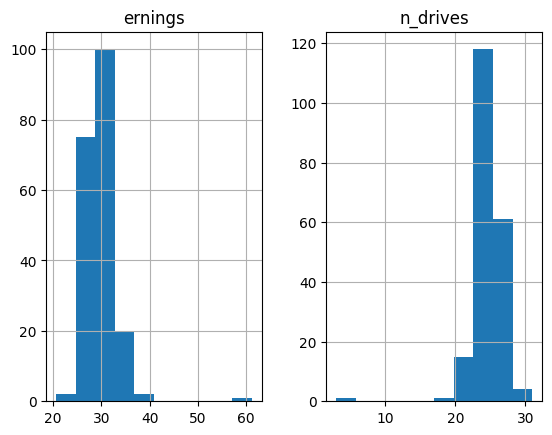

In [90]:
summary_df[['ernings','n_drives']].hist()

# Visualisation

In [91]:
# based on: https://jens-wirelesscar.medium.com/lhexagone-in-hexagons-uber-h3-map-1566bc412172
import folium
from folium.plugins import TimestampedGeoJson
from geojson import Feature, Point, FeatureCollection
import json
import scipy.stats as scs
import matplotlib

def hexagons_dataframe_to_geojson(df_hex, file_output = None, column_name = "value", animated=False):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """
    list_features = []

    for i,row in df_hex.iterrows():
        try:
            geometry_for_row = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"],geo_json=True)]}
            properties = {column_name : row[column_name]}
            if animated:
                # for TimestampedGeoJson times property is needed and style function cannot be passed later
                properties["times"] = [row["times"]]
                properties["style"] = {
                    'fillColor': row["color"],
                    'color': 'black',
                    'weight': 1,
                    'fillOpacity': 0.7
                }
            feature = Feature(geometry = geometry_for_row , id=row["hex_id"], properties = properties)
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row["hex_id"])

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result

def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))

def choropleth_map(df_aggreg, column_name = "value", border_color = 'black', fill_opacity = 0.7, color_map_name = "Blues", initial_map = None, points_list = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """
    #colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    #print(f"Colour column min value {min_value}, max value {max_value}, mean value {mean_value}")
    #print(f"Hexagon cell count: {df_aggreg['hex_id'].nunique()}")

    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)

    if initial_map is None:
        initial_map = folium.Map(location= [59.4, 24.75], zoom_start=10, tiles="cartodbpositron")

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg, column_name = column_name)

    # color_map_name 'Blues' for now, many more at https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity
        },
        name = name_layer
    ).add_to(initial_map)

    if points_list is not None:
        for point in points_list:
            folium.CircleMarker(location=point,
                                radius=2,
                                weight=4,
                                fill_color='res',
                                color = 'red', 
                                fill_opacity=fill_opacity).add_to(initial_map)
    
    return initial_map

def choropleth_map_animated(df_aggreg, column_name = "value", initial_map = None):
    if initial_map is None:
        initial_map = folium.Map(location= [59.4, 24.75], zoom_start=10, tiles="cartodbpositron")

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg, column_name = column_name, animated=True)

    TimestampedGeoJson(
        geojson_data,
        transition_time=200,
        period='PT30M',
        duration='PT30M'
    ).add_to(initial_map)

    return initial_map

In [92]:
bolt_ds.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,distance_in_km,weekday,weekend,hour,start_hexagons,end_hexagons
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,14.205080,6,True,15,88089bc587fffff,88089b1a97fffff
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,2.050095,3,False,11,88089b1a23fffff,88089b1b13fffff
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,0.774715,6,True,14,88089b1a29fffff,88089b1a25fffff
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,3.041401,3,False,9,88089bc58dfffff,88089bc53bfffff
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,9.209442,6,True,0,88089b1a21fffff,88089b18d5fffff


In [93]:
episode_start_time + pd.Timedelta(7,'h')

Timestamp('2022-03-01 13:00:07.936317')

In [94]:
df_hex_start = bolt_ds[bolt_ds.start_time < episode_start_time + pd.Timedelta(30,'m')].groupby("start_hexagons", as_index=False).agg(ride_count=('ride_value', 'count')).rename(columns={"start_hexagons": "hex_id"})
df_hex_start["percentile"] = [scs.percentileofscore(df_hex_start["ride_count"].values, i) for i in df_hex_start["ride_count"].values]

In [95]:
choropleth_map(df_aggreg = df_hex_start, color_map_name = "Blues", column_name = "percentile",points_list=start_points_list)

In [96]:
df_hex_end = bolt_ds[bolt_ds.start_time > episode_end_time - pd.Timedelta(30,'m')].groupby("start_hexagons", as_index=False).agg(ride_count=('ride_value', 'count')).rename(columns={"start_hexagons": "hex_id"})
df_hex_end["percentile"] = [scs.percentileofscore(df_hex_end["ride_count"].values, i) for i in df_hex_end["ride_count"].values]

In [97]:
choropleth_map(df_aggreg = df_hex_start, color_map_name = "Blues", column_name = "percentile", points_list=end_points_list)